In [69]:
from typing import Tuple, Any

import pandas as pd
import numpy as np
from numpy import ndarray, dtype, floating
from numpy._typing import _64Bit
from scipy.stats import gaussian_kde
import seaborn as sns
import scipy.io
import h5py
import mat73
import math

from typing import List

from tqdm import tqdm 
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO

import pyarrow as pa
import pyarrow.parquet as pq

import torch

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import warnings
warnings.filterwarnings("ignore")

In [70]:
ANIMAL_ID = 'Jenkins'
SESSION_ID = '20090918'

BINSIZE = 1e-3
DECIMALS = 3

BINS_BEFORE= 240
BINS_AFTER = 660

N_BINS = BINS_BEFORE + BINS_AFTER

EVENTS = {
    'target_on': 1,
    'gocue_on': 2,
    'move_start': 3,
    'move_end': 4,
}

In [71]:
file = h5py.File(f'/home/makki/data/NWB/000070/sub-Jenkins/sub-{ANIMAL_ID}_ses-{SESSION_ID}_behavior+ecephys.nwb')
io = NWBHDF5IO(file=file, mode='r', load_namespaces=True)

In [72]:
nwb = io.read()
nwb

,x,y,z,imp,location,filtering,group,group_name,gain,offset
id,,,,,,,,,,
1,NaN,NaN,NaN,-1.0,"Pre-Motor Cortex, dorsal",1000Hz,"1 pynwb.ecephys.ElectrodeGroup at 0x139872594469328\nFields:\n description: array corresponding to device implanted at PMd\n device: Utah Array(PMd) pynwb.device.Device at 0x139872594027088\nFields:\n description: 96 channel utah array\n manufacturer: BlackRock Microsystems\n\n location: Caudal, dorsal Pre-motor cortex, Left hemisphere\n",1,1.0,0.0
2,NaN,NaN,NaN,-1.0,"Pre-Motor Cortex, dorsal",1000Hz,"1 pynwb.ecephys.ElectrodeGroup at 0x139872594469328\nFields:\n description: array corresponding to device implanted at PMd\n device: Utah Array(PMd) pynwb.device.Device at 0x139872594027088\nFields:\n description: 96 channel utah array\n manufacturer: BlackRock Microsystems\n\n location: Caudal, dorsal Pre-motor cortex, Left hemisphere\n",1,1.0,0.0
3,NaN,NaN,NaN,-1.0,"Pre-Motor Cortex, dorsal",1000Hz,"1 pynwb.ecephys.ElectrodeGroup at 0x139872594469328\nFields:\n description: array corresponding to device implanted at PMd\n device: Utah Array(PMd) pynwb.device.Device at 0x139872594027088\nFields:\n description: 96 channel utah array\n manufacturer: BlackRock Microsystems\n\n location: Caudal, dorsal Pre-motor cortex, Left hemisphere\n",1,1.0,0.0
4,NaN,NaN,NaN,-1.0,"Pre-Motor Cortex, dorsal",1000Hz,"1 pynwb.ecephys.ElectrodeGroup at 0x139872594469328\nFields:\n description: array corresponding to device implanted at PMd\n device: Utah Array(PMd) pynwb.device.Device at 0x139872594027088\nFields:\n description: 96 channel utah array\n manufacturer: BlackRock Microsystems\n\n location: Caudal, dorsal Pre-motor cortex, Left hemisphere\n",1,1.0,0.0
,x,y,z,imp,location,filtering,group,group_name,gain,offset
id,,,,,,,,,,
1,NaN,NaN,NaN,-1.0,"Pre-Motor Cortex, dorsal",1000Hz,"1 pynwb.ecephys.ElectrodeGroup at 0x139872594469328\nFields:\n description: array corresponding to device implanted at PMd\n device: Utah Array(PMd) pynwb.device.Device at 0x139872594027088\nFields:\n description: 96 channel utah array\n manufacturer: BlackRock Microsystems\n\n location: Caudal, dorsal Pre-motor cortex, Left hemisphere\n",1,1.0,0.0
2,NaN,NaN,NaN,-1.0,"Pre-Motor Cortex, dorsal",1000Hz,"1 pynwb.ecephys.ElectrodeGroup at 0x139872594469328\nFields:\n description: array corresponding to device implanted at PMd\n device: Utah Array(PMd) pynwb.device.Device at 0x139872594027088\nFields:\n description: 96 channel utah array\n manufacturer: BlackRock Microsystems\n\n location: Caudal, dorsal Pre-motor cortex, Left hemisphere\n",1,1.0,0.0
3,NaN,NaN,NaN,-1.0,"Pre-Motor Cortex, dorsal",1000Hz,"1 pynwb.ecephys.ElectrodeGroup at 0x139872594469328\nFields:\n description: array corresponding to device implanted at PMd\n device: Utah Array(PMd) pynwb.device.Device at 0x139872594027088\nFields:\n description: 96 channel utah array\n manufacturer: BlackRock Microsystems\n\n location: Caudal, dorsal Pre-motor cortex, Left hemisphere\n",1,1.0,0.0


In [73]:
trialtable = nwb.trials.to_dataframe()
trialtable

,start_time,stop_time,target_presentation_time,go_cue_time,reaction_time,move_begins_time,move_ends_time,discard_trial,task_success,trial_type,...,correct_reach,maze_num_targets,maze_num_barriers,novel_maze,target_positions,frame_details,hit_target_position,target_size,barrier_info,timeseries
id,,,,,,,,,,,,,,,,,,,,,
0,4.707200,8.567133,5.570200,6.517200,0.335,6.819200,7.234200,0,1,0,...,0,1,2,1,"[[-130, -57]]","[[[-200]], [[200]], [[-155]], [[155]], [[20]]]","[-130, -57]",13,"[[-16.0, 96.0, 59.0, 22.0], [-62.0, -112.0, 43...","[(0, 3226, Eye pynwb.behavior.SpatialSeries at..."
1,9.407200,12.112167,10.172200,10.202200,0.305,10.479200,10.789200,0,1,0,...,0,1,2,1,"[[120, 70]]","[[[-200]], [[200]], [[-155]], [[155]], [[20]]]","[120, 70]",13,"[[-49.0, -59.0, 22.0, 53.0], [-33.0, -100.0, 5...","[(3226, 2081, Eye pynwb.behavior.SpatialSeries..."
2,18.437233,21.972267,19.209233,19.857233,0.300,20.124233,20.584233,0,1,17,...,1,1,9,0,"[[-77, 82]]","[[[-200]], [[200]], [[-155]], [[155]], [[20]]]","[-77, 82]",13,"[[-33.0, 47.0, 6.0, 37.0], [-77.0, 48.0, 11.0,...","[(5307, 2846, Eye pynwb.behavior.SpatialSeries..."
3,22.777233,26.007267,23.495233,23.959233,0.305,24.229233,24.644233,0,1,8,...,1,1,9,0,"[[132, 56]]","[[[-200]], [[200]], [[-155]], [[155]], [[20]]]","[132, 56]",13,"[[-82.0, -43.0, 8.0, 118.0], [145.0, -105.0, 1...","[(8153, 2566, Eye pynwb.behavior.SpatialSeries..."
4,26.937267,30.317267,27.630267,28.211267,0.300,28.479267,28.979267,0,1,29,...,1,1,9,0,"[[2, 82]]","[[[-200]], [[200]], [[-155]], [[155]], [[20]]]","[2, 82]",13,"[[-9.0, 52.0, 8.0, 43.0], [-50.0, 91.0, 64.0, ...","[(10719, 2741, Eye pynwb.behavior.SpatialSerie..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2631,15586.530559,15590.185559,15587.318559,15587.932559,0.315,15588.212559,15588.807559,0,1,13,...,1,1,8,0,"[[132, 56]]","[[[-200]], [[200]], [[-155]], [[155]], [[20]]]","[132, 56]",13,"[[-64.0, -47.0, 113.0, 7.0], [-64.0, -39.0, 40...","[(7990376, 2976, Eye pynwb.behavior.SpatialSer..."
2632,15591.780559,15594.615592,15592.688559,15593.202559,0.360,15593.532559,NaN,0,0,13,...,0,1,8,0,"[[132, 56]]","[[[-200]], [[200]], [[-155]], [[155]], [[20]]]","[132, 56]",13,"[[-64.0, -47.0, 113.0, 7.0], [-64.0, -39.0, 40...","[(7993352, 2831, Eye pynwb.behavior.SpatialSer..."
2633,15599.680592,15602.685592,15600.425592,15600.488592,0.365,15600.822592,15601.287592,0,1,29,...,1,1,9,0,"[[2, 82]]","[[[-200]], [[200]], [[-155]], [[155]], [[20]]]","[2, 82]",13,"[[-9.0, 52.0, 8.0, 43.0], [-50.0, 91.0, 64.0, ...","[(7996183, 2306, Eye pynwb.behavior.SpatialSer..."


In [74]:
n_trials = len(trialtable)
print(n_trials)
n_neurons = nwb.units.to_dataframe()['spike_times'].shape[0]
print(n_neurons)

2636
192


In [76]:
trialtable.task_success.value_counts()

task_success
1    2570
0      66
Name: count, dtype: int64

In [55]:
trialtable.correct_reach.value_counts()

correct_reach
1    2296
0     340
Name: count, dtype: int64

In [56]:
for column in trialtable.columns:
    print(column)

start_time
stop_time
target_presentation_time
go_cue_time
reaction_time
move_begins_time
move_ends_time
discard_trial
task_success
trial_type
trial_version
proto_trial
maze_condition
correct_reach
maze_num_targets
maze_num_barriers
novel_maze
target_positions
frame_details
hit_target_position
target_size
barrier_info
timeseries


In [52]:
data = {
    'animal_id': [],
    'session_id': [],
    'trial_id': [],
    'spikes': [],
    'hand_pos': [],
    'cursor_pos': [],
    'hand_vel': [],
    'cursor_vel': [],
    #'typical_reach': [],
    #'mean_reach': [],
    'reach_angle_rad': [],
    'reach_angle_deg': [],
    'reach_color': [],
}

info = {
    'animal_id': [],
    'session_id': [],
    'trial_id': [],
    'correct_reach': [],
    'task_success': [],
}

maze = {
    'animal_id': [],
    'session_id': [],
    'trial_id': [],
    'trial_type': [],
    'trial_version': [],
    'maze_condition': [],
    'maze_num_targets': [],
    'maze_num_barriers': [],
    'targets_position':[],
    'true_target': [],
    'target_size': [],
}

events = {
    'animal_id': [],
    'session_id': [],
    'trial_id': [],
    'start_time': [],
    'stop_time': [],
    'trial_len': [],
    'target_on_time': [],
    'gocue_on_time': [],
    'move_starts_time': [],
    'move_ends_time': [],
    'delay_time': [],
    'reaction_time': [],
    'movement_exec_time': [],
}

neurons = nwb.units.to_dataframe()['spike_times'] # Neuron id x Spike Time
hand = nwb.processing['behavior'].data_interfaces['Position'].spatial_series['Hand'].data[:] # x, y 
cursor = nwb.processing['behavior'].data_interfaces['Position'].spatial_series['Cursor'].data[:] # x, y
session_time = np.round(nwb.processing['behavior'].data_interfaces['Position'].spatial_series['Hand'].timestamps[:] + 0.0001, decimals=3)

for trial_id in tqdm(range(0, n_trials)):
    
    """defining the grid/mask for trial"""
    dt = 0.001 #seconds
    
    min_T = np.round(trialtable['start_time'][trial_id], decimals=3) # Trial start time
    max_T = np.round(trialtable['stop_time'][trial_id], decimals=3) # Trial end time
    
    mi = np.nonzero(session_time > min_T)[0][0]
    ma = np.nonzero(session_time < max_T)[0][-1]

    grid = np.round(np.arange(min_T, max_T + dt, dt), decimals=3)
    n_bins = len(grid)
    
    """fill spiking and behavioral data"""
    
    spikes = np.zeros((n_bins, n_neurons))
    for n in range(n_neurons):
        spikes[:, n] = np.isin(grid, np.round(neurons[n], decimals=3)).astype(int)
    
    hand_pos = np.zeros((n_bins, 2))
    _, hand_pos[:, 0] = np.histogram(hand[mi:ma, 0], bins=n_bins-1)
    _, hand_pos[:, 1] = np.histogram(hand[mi:ma, 1], bins=n_bins-1)
    
    cursor_pos = np.zeros((n_bins, 2))
    _, cursor_pos[:, 0] = np.histogram(cursor[mi:ma,0], bins=n_bins-1)
    _, cursor_pos[:, 1] = np.histogram(cursor[mi:ma,1], bins=n_bins-1)
    
    hand_vel = pos_to_vel(hand_pos, dt)
    cursor_vel = pos_to_vel(cursor_pos, dt)

    #reach_angle_rad = np.atan2(hand_pos[-1, 0], hand_pos[-1, 1])
    reach_angle_rad = torch.atan2(torch.tensor(hand_pos[-1, 0]), torch.tensor(hand_pos[-1, 1])).numpy().astype(float)
    reach_angle_deg = np.rad2deg(reach_angle_rad) + 360 / 2
    reach_color = plt.cm.hsv(reach_angle_rad / (2 * np.pi) + 0.5)
    
    """fill trial info / meta data"""
    task_success = trialtable['task_success'][trial_id]
    correct_reach = trialtable['correct_reach'][trial_id]
    
    """fill maze info"""
    trial_type = trialtable['trial_type'][trial_id]
    trial_version = trialtable['trial_version'][trial_id]
    maze_condition = trialtable['maze_condition'][trial_id]
    num_targets = trialtable['maze_num_targets'][trial_id]
    num_barriers = trialtable['maze_num_barriers'][trial_id]
    targets_pos = trialtable['target_positions'][trial_id]
    target_size = trialtable['target_size'][trial_id]
    true_target = trialtable['hit_target_position'][trial_id]
    
    """fill events and timing data"""
    start_time = np.round(trialtable['start_time'][trial_id], decimals=3)
    stop_time = np.round(trialtable['stop_time'][trial_id], decimals=3)
    trial_len = stop_time - start_time
    target_on_time = np.round(trialtable['target_presentation_time'][trial_id], decimals=3)
    gocue_on_time = np.round(trialtable['go_cue_time'][trial_id], decimals=3)
    move_starts_time = np.round(trialtable['move_begins_time'], decimals=3)
    move_ends_time = np.round(trialtable['move_ends_time'][trial_id], decimals=3)
    move_exec_time = move_ends_time - move_starts_time
    reaction_time = np.round(trialtable['reaction_time'][trial_id], decimals=3)
    delay_time = gocue_on_time - target_on_time

    data['animal_id'].append(animal_id)
    data['session_id'].append(session_id)
    data['trial_id'].append(trial_id)
    data['spikes'].append(torch.tensor(spikes, dtype=torch.float32))
    data['hand_pos'].append(torch.tensor(hand_pos, dtype=torch.float32))
    data['cursor_pos'].append(torch.tensor(cursor_pos, dtype=torch.float32))
    data['hand_vel'].append(torch.tensor(hand_vel, dtype=torch.float32))
    data['cursor_vel'].append(torch.tensor(cursor_vel, dtype=torch.float32))
    data['reach_angle_rad'].append(reach_angle_rad)
    data['reach_angle_deg'].append(reach_angle_deg)
    data['reach_color'].append(reach_color)
    
    info['animal_id'].append(animal_id)
    info['session_id'].append(session_id)
    info['trial_id'].append(trial_id)
    info['correct_reach'].append(correct_reach)
    info['task_success'].append(task_success)
    
    events['animal_id'].append(animal_id)
    events['session_id'].append(session_id)
    events['trial_id'].append(trial_id)
    events['start_time'].append(start_time)
    events['stop_time'].append(stop_time)
    events['trial_len'].append(stop_time)
    events['target_on_time'].append(target_on_time)
    events['gocue_on_time'].append(gocue_on_time)
    events['move_starts_time'].append(gocue_on_time)
    events['move_ends_time'].append(gocue_on_time)
    events['delay_time'].append(delay_time)
    events['reaction_time'].append(reaction_time)
    events['movement_exec_time'].append(move_exec_time)
    
    maze['animal_id'].append(animal_id)
    maze['session_id'].append(session_id)
    maze['trial_id'].append(trial_id)
    maze['trial_type'].append(trial_type)
    maze['trial_version'].append(trial_version)
    maze['maze_condition'].append(maze_condition)
    maze['maze_num_targets'].append(num_targets)
    maze['maze_num_barriers'].append(num_barriers)
    maze['targets_position'].append(targets_pos)
    maze['true_target'].append(true_target)
    maze['target_size'].append(target_size)

  0%|          | 0/2636 [00:00<?, ?it/s]


NameError: name 'pos_to_vel' is not defined

In [ ]:
data_df = pd.DataFrame(data)
info_df = pd.DataFrame(info)
events_df = pd.DataFrame(events)
maze_df = pd.DataFrame(maze)

In [15]:
dataset = df_concat = pd.concat([data_df, info_df, events_df, maze_df], axis=1)

NameError: name 'data_df' is not defined

In [16]:
dataset = dataset[dataset.task_success == 1]
trialtable = dataset
typ = dataset[dataset.correct_reach == 1]
dev = dataset[dataset.correct_reach == 0]

NameError: name 'dataset' is not defined

In [10]:
trialtable = trialtable[trialtable.task_success == 1]
typ = trialtable[trialtable.correct_reach == 1]
dev = trialtable[trialtable.correct_reach == 0]

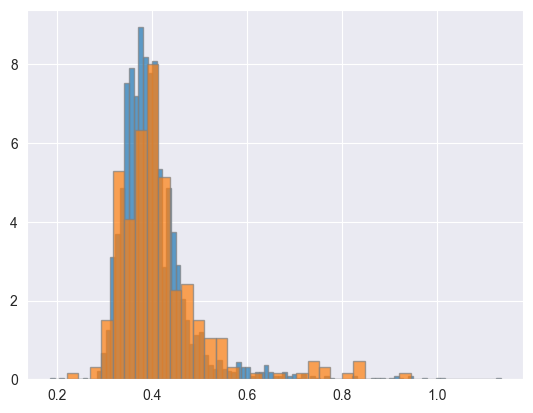

In [11]:
plt.hist(typ.reaction_time, bins='auto', density=True, alpha=0.7, edgecolor='gray')
plt.hist(dev.reaction_time, bins='auto', density=True, alpha=0.7, edgecolor='gray')
plt.show()

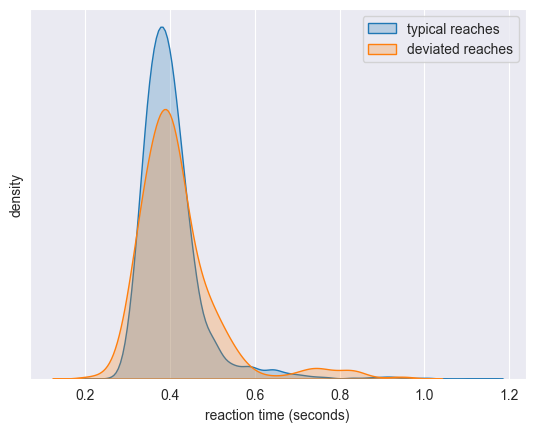

In [12]:
typ_rt = trialtable[(trialtable.correct_reach == 1)].reaction_time.values
dev_rt = trialtable[(trialtable.correct_reach == 0)].reaction_time.values

sns.kdeplot(typ_rt, fill=True, label='typical reaches')
sns.kdeplot(dev_rt, fill=True, label='deviated reaches')

plt.title('')
plt.xlabel('reaction time (seconds)')
plt.ylabel('density')
plt.yticks([])
plt.legend()
plt.savefig('/home/makki/opium/output_figs/reaction_time.png')
plt.show()


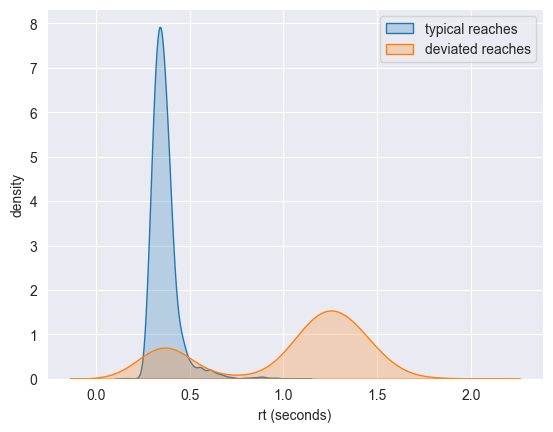

In [75]:
typ_delay = trialtable[(trialtable.correct_reach == 1)].move_begins_time.values - trialtable[(trialtable.correct_reach == 1)].go_cue_time.values
dev_delay = trialtable[(trialtable.correct_reach == 0)].move_begins_time.values - trialtable[(trialtable.correct_reach == 0)].go_cue_time.values

sns.kdeplot(typ_delay, fill=True, label='typical reaches')
sns.kdeplot(dev_delay, fill=True, label='deviated reaches')

plt.title('')
plt.xlabel('rt (seconds)')
plt.ylabel('density')
plt.legend()
plt.savefig('/home/makki/opium/output_figs/delay_time.png')
plt.show()

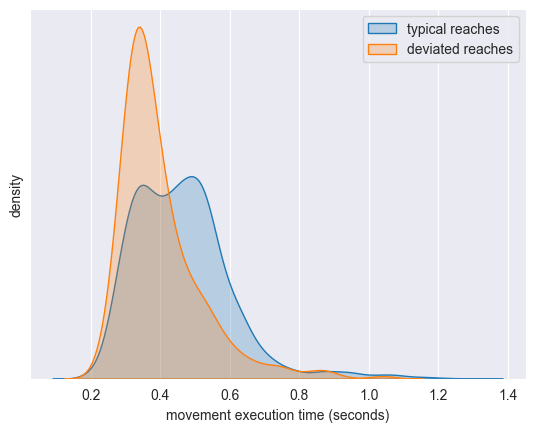

In [14]:
typ_mv_exec = trialtable[(trialtable.correct_reach == 1)].move_ends_time.values - trialtable[(trialtable.correct_reach == 1)].move_begins_time.values
dev_mv_exec = trialtable[(trialtable.correct_reach == 0)].move_ends_time.values - trialtable[(trialtable.correct_reach == 0)].move_begins_time.values

sns.kdeplot(typ_mv_exec, fill=True, label='typical reaches')
sns.kdeplot(dev_mv_exec, fill=True, label='deviated reaches')

plt.title('')
plt.xlabel('movement execution time (seconds)')
plt.ylabel('density')
plt.yticks([])
plt.legend()
plt.savefig('/home/makki/opium/output_figs/movement_execution_time.png')
plt.show()

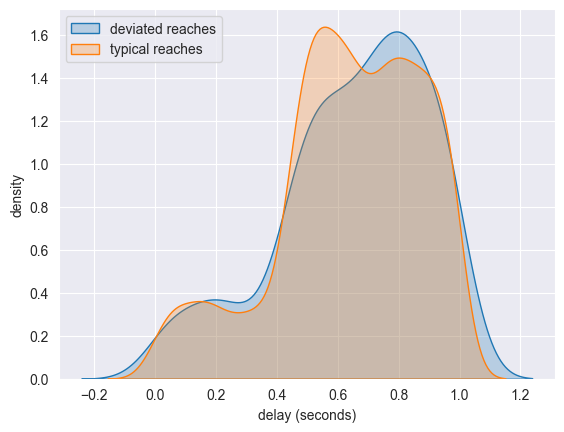

In [15]:
typ_delay = trialtable[(trialtable.correct_reach == 1)].go_cue_time.values - trialtable[(trialtable.correct_reach == 1)].target_presentation_time.values
dev_delay = trialtable[(trialtable.correct_reach == 0)].go_cue_time.values - trialtable[(trialtable.correct_reach == 0)].target_presentation_time.values

sns.kdeplot(dev_delay, fill=True, label='deviated reaches')
sns.kdeplot(typ_delay, fill=True, label='typical reaches')

plt.title('')
plt.xlabel('delay (seconds)')
plt.ylabel('density')
plt.legend()
plt.savefig('/home/makki/opium/output_figs/delay_time.png')
plt.show()

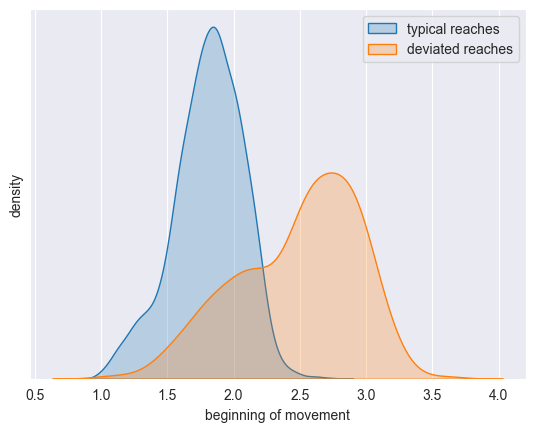

In [16]:
typ_mv_beg = trialtable[(trialtable.correct_reach == 1)].move_begins_time.values - trialtable[(trialtable.correct_reach == 1)].start_time.values
dev_mv_beg = trialtable[(trialtable.correct_reach == 0)].move_begins_time.values - trialtable[(trialtable.correct_reach == 0)].start_time.values

sns.kdeplot(typ_mv_beg, fill=True, label='typical reaches')
sns.kdeplot(dev_mv_beg, fill=True, label='deviated reaches')

plt.title('')
plt.xlabel('beginning of movement')
plt.ylabel('density')
plt.yticks([])
plt.legend()
plt.savefig('/home/makki/opium/output_figs/movement_begins.png')
plt.show()

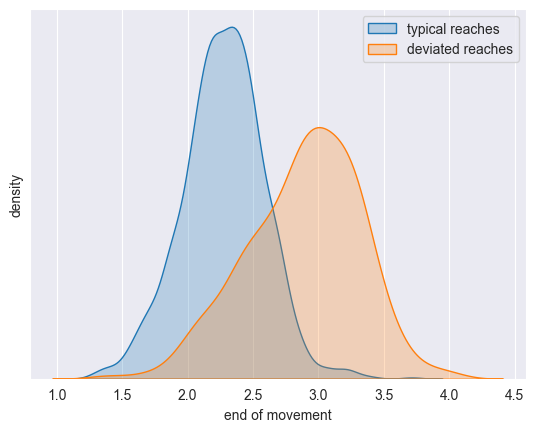

In [17]:
typ_mv_end = trialtable[(trialtable.correct_reach == 1)].move_ends_time.values - trialtable[(trialtable.correct_reach == 1)].start_time.values
dev_mv_end = trialtable[(trialtable.correct_reach == 0)].move_ends_time.values - trialtable[(trialtable.correct_reach == 0)].start_time.values

sns.kdeplot(typ_mv_end, fill=True, label='typical reaches')
sns.kdeplot(dev_mv_end, fill=True, label='deviated reaches')

plt.title('')
plt.xlabel('end of movement')
plt.ylabel('density')
plt.yticks([])
plt.legend()
plt.savefig('/home/makki/opium/output_figs/movement_ends.png')
plt.show()

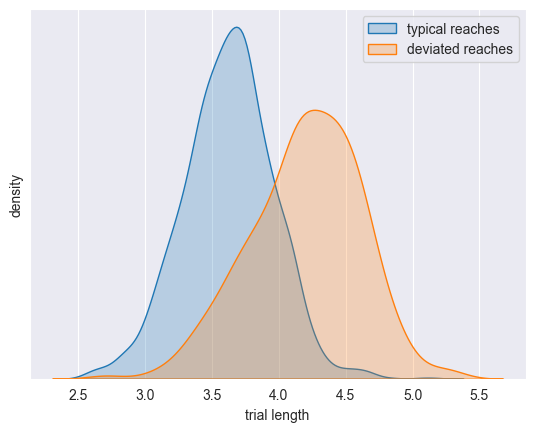

In [18]:
typ_trial_len = trialtable[(trialtable.correct_reach == 1)].stop_time.values - trialtable[(trialtable.correct_reach == 1)].start_time.values
dev_trial_len = trialtable[(trialtable.correct_reach == 0)].stop_time.values - trialtable[(trialtable.correct_reach == 0)].start_time.values

sns.kdeplot(typ_trial_len, fill=True, label='typical reaches')
sns.kdeplot(dev_trial_len, fill=True, label='deviated reaches')

plt.title('')
plt.xlabel('trial length')
plt.ylabel('density')
plt.yticks([])
plt.legend()
plt.savefig('/home/makki/opium/output_figs/trial_length.png')
plt.show()

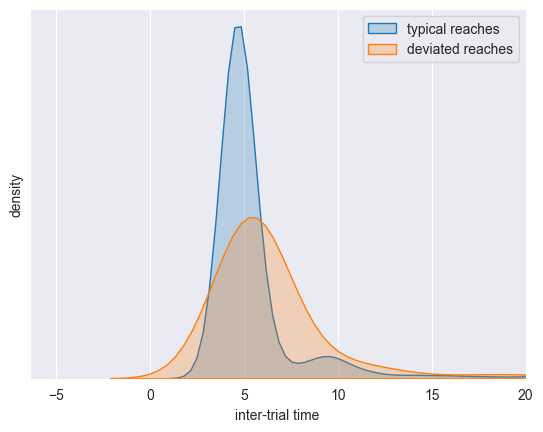

In [35]:
typ_trials = trialtable[(trialtable.correct_reach == 1)]
dev_trials = trialtable[(trialtable.correct_reach == 0)]
    
iti = np.array([trialtable.iloc[trial_id+1].start_time - trialtable.iloc[trial_id].start_time for trial_id in range(n_trials-1)])

sns.kdeplot(iti[typ_trials.index.tolist()[:-1]], fill=True, label='typical reaches')
sns.kdeplot(iti[dev_trials.index.tolist()[:-1]], fill=True, label='deviated reaches')

plt.title('')
plt.xlabel('inter-trial time')
plt.ylabel('density')
plt.yticks([])
plt.legend()
plt.xlim(right=20)
plt.savefig('/home/makki/opium/output_figs/intertrial_time.png')
plt.show()

In [57]:
trialtable.trial_id

AttributeError: 'DataFrame' object has no attribute 'trial_id'

### Out-of-sample Behavioral Analysis

In [13]:
trialtable = trialtable[trialtable.task_success == 1].reset_index()

trialtable['trial_id'] = trialtable.index
trialtable['animal_id'] = ANIMAL_ID
trialtable['session_id'] = SESSION_ID

proto_trials = trialtable[trialtable.proto_trial == 1].reset_index()
typ_trials = trialtable[trialtable.correct_reach == 1].reset_index()
dev_trials = trialtable[trialtable.correct_reach == 0].reset_index()

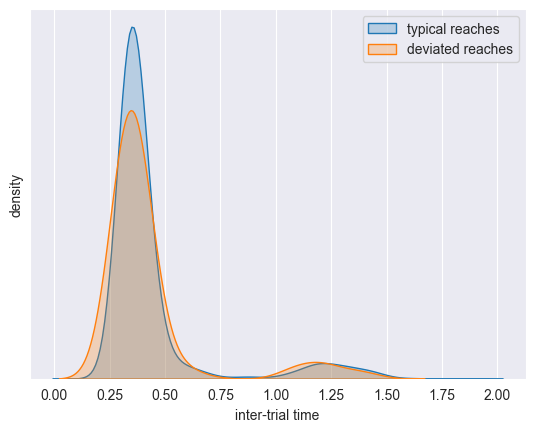

In [78]:
rt = np.array([trialtable.iloc[trial_id].move_begins_time - trialtable.iloc[trial_id].go_cue_time for trial_id in range(len(trialtable))])

sns.kdeplot(rt[typ_trials.index.tolist()[:-1]], fill=True, label='typical reaches')
sns.kdeplot(rt[dev_trials.index.tolist()[:-1]], fill=True, label='deviated reaches')

plt.title('')
plt.xlabel('inter-trial time')
plt.ylabel('density')
plt.yticks([])
plt.legend()
plt.savefig('/home/makki/opium/output_figs/intertrial_time.png')
plt.show()

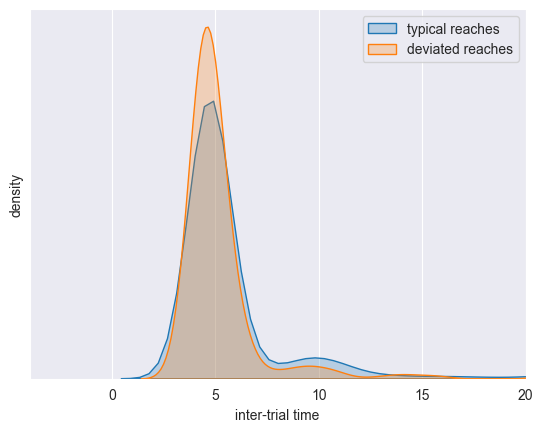

In [54]:
iti = np.array([trialtable.iloc[trial_id+1].start_time - trialtable.iloc[trial_id].start_time for trial_id in range(len(trialtable)-1)])

sns.kdeplot(iti[typ_trials.index.tolist()[:-1]], fill=True, label='typical reaches')
sns.kdeplot(iti[dev_trials.index.tolist()[:-1]], fill=True, label='deviated reaches')

plt.title('')
plt.xlabel('inter-trial time')
plt.ylabel('density')
plt.yticks([])
plt.legend()
plt.xlim(right=20)
plt.savefig('/home/makki/opium/output_figs/intertrial_time.png')
plt.show()

In [135]:
trialtable.maze_condition.value_counts()

maze_condition
0     202
49     29
37     29
71     27
70     27
     ... 
93     18
87     17
14     17
92     17
27     16
Name: count, Length: 109, dtype: int64

In [56]:
"""
Note that there are no typical trials with the maze condition 0. 
"""
typ_trials.maze_condition.value_counts()

maze_condition
49    28
37    28
71    27
70    27
30    26
      ..
2     16
15    16
88    16
27    15
14    15
Name: count, Length: 108, dtype: int64

In [57]:
"""
Note that all trials with the maze condition 0 have deviated reaches.. 
"""
dev_trials.maze_condition.value_counts()

maze_condition
0     202
51      7
90      4
3       4
15      4
89      3
88      3
59      3
75      3
10      3
43      2
2       2
17      2
39      2
33      2
66      2
60      2
32      2
14      2
38      2
37      1
65      1
1       1
7       1
44      1
64      1
23      1
56      1
76      1
93      1
50      1
31      1
91      1
49      1
27      1
69      1
45      1
67      1
Name: count, dtype: int64

2.5498666666680947
5.2748666666666395
3.6827692347600447


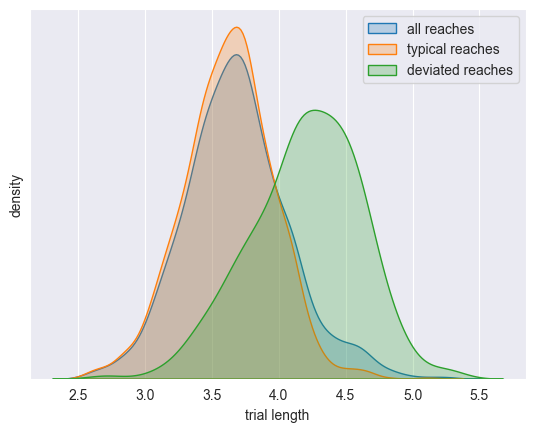

In [59]:
""""trials length distributio"""

trial_len = trialtable.stop_time.values - trialtable.start_time.values
typ_trial_len = typ_trials.stop_time.values - typ_trials.start_time.values
dev_trial_len = dev_trials.stop_time.values - dev_trials.start_time.values

sns.kdeplot(trial_len, fill=True, label='all reaches')
sns.kdeplot(typ_trial_len, fill=True, label='typical reaches')
sns.kdeplot(dev_trial_len, fill=True, label='deviated reaches')

print(trial_len.min())
print(trial_len.max())
print(trial_len.mean())

plt.title('')
plt.xlabel('trial length')
plt.ylabel('density')
plt.yticks([])
plt.legend()
#plt.savefig('/home/makki/opium/output_figs/trial_length.png')
plt.show()

2.7049666666666656
5.2748666666666395
4.346518481848206


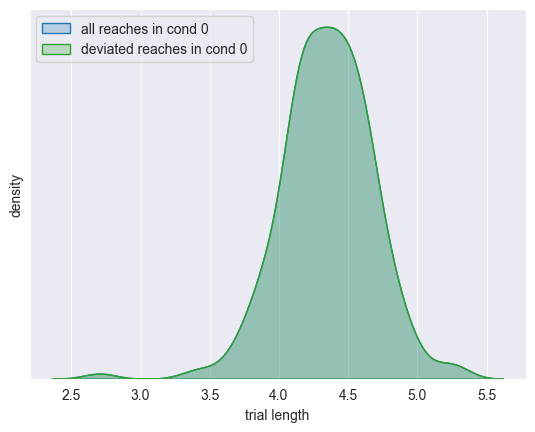

In [60]:
"""trials length distributio per specific maze condition"""

#trial_len = trialtable.stop_time.values - trialtable.start_time.values
#typ_trial_len = typ_trials.stop_time.values - typ_trials.start_time.values
#dev_trial_len = dev_trials.stop_time.values - dev_trials.start_time.values

cond_inspec = 0

trial_len = trialtable[trialtable.maze_condition == cond_inspec].stop_time.values - trialtable[trialtable.maze_condition == cond_inspec].start_time.values
typ_trial_len = typ_trials[typ_trials.maze_condition == cond_inspec].stop_time.values - typ_trials[typ_trials.maze_condition == cond_inspec].start_time.values
dev_trial_len = dev_trials[dev_trials.maze_condition == cond_inspec].stop_time.values - dev_trials[dev_trials.maze_condition == cond_inspec].start_time.values

sns.kdeplot(trial_len, fill=True, label=f'all reaches in cond {cond_inspec}')
sns.kdeplot(typ_trial_len, fill=True, label=f'typical reaches in cond {cond_inspec}')
sns.kdeplot(dev_trial_len, fill=True, label=f'deviated reaches in cond {cond_inspec}')

print(trial_len.min())
print(trial_len.max())
print(trial_len.mean())

plt.title('')
plt.xlabel('trial length')
plt.ylabel('density')
plt.yticks([])
plt.legend()
#plt.savefig('/home/makki/opium/output_figs/trial_length.png')
plt.show()

In [14]:
DECIMALS = 3 #of second
BINSIZE_MS = 20
BINSIZE = BINSIZE_MS * pow(10, -DECIMALS)

BINS_BEFORE = int(np.ceil(800/BINSIZE_MS))
BINS_AFTER = int(np.ceil(1200/BINSIZE_MS))

hand_data = nwb.processing['behavior'].data_interfaces['Position'].spatial_series['Hand'].data[:] # x, y 
cursor_data = nwb.processing['behavior'].data_interfaces['Position'].spatial_series['Cursor'].data[:] # x, y
session_time = np.round(nwb.processing['behavior'].data_interfaces['Position'].spatial_series['Hand'].timestamps[:] + 0.0001, decimals=DECIMALS)

neurons = nwb.units.to_dataframe()['spike_times'] # Neuron id x Spike Time
targeton = np.round(trialtable['target_presentation_time'], decimals=DECIMALS)
gocue = np.round(trialtable['go_cue_time'], decimals=DECIMALS)
startmov = np.round(trialtable['move_begins_time'], decimals=DECIMALS)
endmov = np.round(trialtable['move_ends_time'], decimals=DECIMALS)
reactiontime = np.round(trialtable['reaction_time'], decimals=DECIMALS)

conds = trialtable['maze_condition'].values

true_targets = trialtable['hit_target_position'].values

n_trials = len(trialtable)
n_typ_trials = len(typ_trials)
n_dev_trials = len(dev_trials)
n_neurons = neurons.shape[0]

In [72]:
e = startmov.values - gocue.values

In [74]:
e[e < 0]

array([], dtype=float64)

In [24]:
def make_grid(trialtable: pd.DataFrame, trial_id:int, dt:float) -> tuple:
    
    min_T = np.round(trialtable['start_time'][trial_id], decimals=DECIMALS) # Trial start time
    max_T = np.round(trialtable['stop_time'][trial_id], decimals=DECIMALS) # Trial end time

    mi = np.nonzero(session_time > min_T)[0][0]
    ma = np.nonzero(session_time < max_T)[0][-1]

    grid = np.arange(min_T, max_T + dt, dt) #seconds
    grid = np.round(grid, decimals=DECIMALS)
    
    return (min_T, max_T, mi, ma, grid)


def pos_to_vel(pos: np.ndarray) -> torch.Tensor:
    return np.diff(pos, axis=0)


def where(ev, grid):
    try:
        return np.where(grid == ev)[0][-1]
    except IndexError:
        return (np.abs(grid - ev)).argmin()
            
            
def get_events_bin(trialtable: pd.DataFrame, dt: float) -> torch.Tensor:
    
    event_bins = []
    
    for trial_id in tqdm(range(len(trialtable))):

        min_T, max_T, mi, ma, grid = make_grid(trialtable, trial_id, dt)
        n_bins = len(grid)
        events_binned = np.zeros((n_bins,))
                
        if targeton[trial_id] > 0:
            ti = where(grid, targeton[trial_id])
            events_binned[ti] = 1 #target on
            
        if gocue[trial_id] > 0 and gocue[trial_id] <= grid[-1]:
            gi = where(grid, gocue[trial_id])
            if gi == ti:
                gi += 1
            events_binned[gi] = 2 #go cue
    
        if startmov[trial_id] > 0:
            events_binned[where(grid, startmov[trial_id])] = 3 #move start
    
        if endmov[trial_id] > 0:
            events_binned[where(grid, endmov[trial_id])] = 4 #move end
            
        event_bins.append(events_binned)
            
    return event_bins


def binned_behavior(trialtable: pd.DataFrame, pos_data: pd.DataFrame, dt: float) -> tuple[torch.Tensor, torch.Tensor]:
    
    pos = []
    vel = []
    for trial_id in tqdm(range(len(trialtable))):
        
        min_T, max_T, mi, ma, grid = make_grid(trialtable, trial_id, dt)
        n_bins = len(grid)
        
        pos_binned = np.zeros((n_bins, 2))
        _, pos_binned[:, 0] = np.histogram(pos_data[mi:ma, 0], bins=n_bins-1)
        _, pos_binned[:, 1] = np.histogram(pos_data[mi:ma, 1], bins=n_bins-1)
        pos.append(torch.tensor(pos_binned, dtype=torch.float64))
        
        vel_binned = pos_to_vel(pos_binned)
        vel.append(torch.tensor(vel_binned, dtype=torch.float64))
        
    return (pos, vel)


def align_event(timeseries, events: List, event_idx: int, bins_before: int, bins_after: int) -> torch.Tensor:
    
    n_trials = len(timeseries)
    n_bins = bins_before + bins_after
    seq = torch.zeros((n_trials, n_bins, 2))
    
    for trial_id in tqdm(range(n_trials)):
        ei = where(events[trial_id], event_idx)
        #ei = np.where(events[trial_id] == event_idx)[0][0]
        seq[trial_id] = timeseries[trial_id][ei-bins_before : ei+bins_after, :]
        
    return seq


def cond_avg_reaches(reaches: torch.Tensor, trialtable: pd.DataFrame) -> torch.Tensor:
    
    conds = torch.tensor(trialtable.maze_condition.values)
    uniq_conds, _ = torch.tensor(trialtable.maze_condition.unique()).sort()
    n_conds = uniq_conds.shape[0]
    _, n_bins, _= reaches.shape
    avg_reaches = torch.zeros((n_conds, n_bins, 2))
    
    for ci, cond in enumerate(uniq_conds):
        avg_reaches[ci] = torch.mean(reaches[conds == cond], axis=0)

    return avg_reaches

In [25]:
events = get_events_bin(trialtable, BINSIZE)

100%|██████████| 2570/2570 [00:25<00:00, 99.67it/s] 


In [35]:
def get_events_bin(trialtable: pd.DataFrame, dt: float) -> torch.Tensor:
    
    event_bins = {'ids': [], 'seqs': []}
    
    for trial_id in tqdm(range(len(trialtable))):

        min_T, max_T, mi, ma, grid = make_grid(trialtable, trial_id, dt)
        n_bins = len(grid)
        events_binned = np.zeros((n_bins,))
                
        if targeton[trial_id] > 0:
            ti = where(grid, targeton[trial_id])
            events_binned[ti] = 1 #target on
            
        if gocue[trial_id] > 0 and gocue[trial_id] <= grid[-1]:
            gi = where(grid, gocue[trial_id])
            if gi == ti:
                gi += 1
            events_binned[gi] = 2 #go cue
    
        if startmov[trial_id] > 0:
            events_binned[where(grid, startmov[trial_id])] = 3 #move start
    
        if endmov[trial_id] > 0:
            events_binned[where(grid, endmov[trial_id])] = 4 #move end
        
        event_bins['ids'].append(trial_id)
        event_bins['seqs'].append(events_binned)
            
    return event_bins

events = get_events_bin(trialtable, BINSIZE)

100%|██████████| 2570/2570 [00:25<00:00, 100.05it/s]


In [38]:
import pickle

with open("/home/makki/opium/output_figs/event_bins.pkl", "wb") as pickle_file:
    pickle.dump(events, pickle_file)

In [34]:
import json

with open("/home/makki/opium/output_figs/event_bins.json", "w") as json_file:
    json.dump(events, json_file)

In [66]:
hand_pos_binned, hand_vel_binned = binned_behavior(trialtable, hand_data, dt=BINSIZE)
cursor_pos_binned, cursor_vel_binned = binned_behavior(trialtable, cursor_data, dt=BINSIZE)

100%|██████████| 2570/2570 [00:26<00:00, 96.75it/s]


In [114]:
hand_pos = align_event(hand_pos_binned, events, EVENTS['gocue_on'], BINS_BEFORE, BINS_AFTER)
hand_vel = align_event(hand_vel_binned, events, EVENTS['gocue_on'], BINS_BEFORE, BINS_AFTER)

100%|██████████| 2570/2570 [00:00<00:00, 122378.71it/s]


In [68]:
move

0           5.570
1          10.172
2          19.209
3          23.495
4          27.630
          ...    
2565    15564.875
2566    15587.319
2567    15600.426
2568    15634.242
2569    15665.441
Name: target_presentation_time, Length: 2570, dtype: float64

### Different alignment windows

In [172]:
DECIMALS = 3 #of second
BINSIZE_MS = 20
BINSIZE = BINSIZE_MS * pow(10, -DECIMALS)

BINS_BEFORE = int(np.ceil(600/BINSIZE_MS))
BINS_AFTER = int(np.ceil(1200/BINSIZE_MS))

hand_data = nwb.processing['behavior'].data_interfaces['Position'].spatial_series['Hand'].data[:] # x, y 
cursor_data = nwb.processing['behavior'].data_interfaces['Position'].spatial_series['Cursor'].data[:] # x, y
session_time = np.round(nwb.processing['behavior'].data_interfaces['Position'].spatial_series['Hand'].timestamps[:] + 0.0001, decimals=DECIMALS)

neurons = nwb.units.to_dataframe()['spike_times'] # Neuron id x Spike Time
targeton = np.round(trialtable['target_presentation_time'], decimals=DECIMALS)
gocue = np.round(trialtable['go_cue_time'], decimals=DECIMALS)
startmov = np.round(trialtable['move_begins_time'], decimals=DECIMALS)
endmov = np.round(trialtable['move_ends_time'], decimals=DECIMALS)
reactiontime = np.round(trialtable['reaction_time'], decimals=DECIMALS)

conds = trialtable['maze_condition'].values

true_targets = trialtable['hit_target_position'].values

n_trials = len(trialtable)
n_typ_trials = len(typ_trials)
n_dev_trials = len(dev_trials)
n_neurons = neurons.shape[0]

In [180]:
gocue[248]

np.float64(1272.232)

In [182]:
hand_pos_binned[248].shape

torch.Size([185, 2])

In [184]:
where(events[248], 2)

np.int64(37)

In [185]:
where(events[248], 2) * 20

np.int64(740)

In [181]:
events[248]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [174]:
events = get_events_bin(trialtable, BINSIZE)

100%|██████████| 2570/2570 [00:25<00:00, 101.84it/s]


In [175]:
hand_pos_binned, hand_vel_binned = binned_behavior(trialtable, hand_data, dt=BINSIZE)
cursor_pos_binned, cursor_vel_binned = binned_behavior(trialtable, cursor_data, dt=BINSIZE)

100%|██████████| 2570/2570 [00:25<00:00, 99.45it/s] 


In [176]:
hand_pos = align_event(hand_pos_binned, events, EVENTS['gocue_on'], BINS_BEFORE, BINS_AFTER)
hand_vel = align_event(hand_vel_binned, events, EVENTS['gocue_on'], BINS_BEFORE, BINS_AFTER)

 10%|▉         | 248/2570 [00:00<00:00, 70727.37it/s]


RuntimeError: The expanded size of the tensor (100) must match the existing size (0) at non-singleton dimension 0.  Target sizes: [100, 2].  Tensor sizes: [0, 2]

In [168]:
hand_pos_binned[1].shape

torch.Size([137, 2])

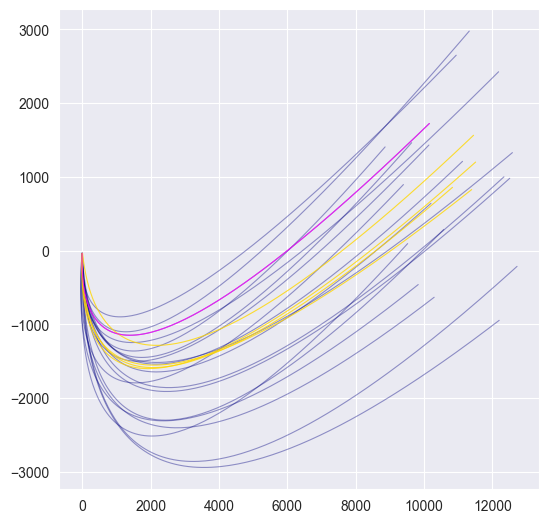

In [145]:
cond = 3
true_target = true_targets[trialtable[trialtable.maze_condition == cond].trial_id.values][0]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

'''
for trial_id in trialtable[trialtable.maze_condition == cond].trial_id.values:
    traj = torch.cumsum(hand_pos_binned[trial_id], dim=0) #- hand_pos[mask].mean(dim=0)[0]
    #reach_angle = torch.atan2(traj[ -1, 0], traj[-1, 1])
    reach_angle = np.atan2(true_target[0], true_target[1])
    #reach_angles_deg = torch.rad2deg(reach_angle) + 360 / 2
    reach_colors = plt.cm.hsv(reach_angle / (2 * np.pi) + 0.5)

    ax.plot(traj[:, 0], traj[:, 1], linewidth=0.7, color=plt.cm.hsv(reach_angle / (2*np.pi) + 0.5))
'''

for trial_id in typ_trials[typ_trials.maze_condition == cond].trial_id.values:
    traj = torch.cumsum(hand_pos_binned[trial_id], dim=0)
    ax.plot(traj[:, 0], traj[:, 1], linewidth=0.8, alpha=0.4, color='navy')
    
for trial_id in dev_trials[dev_trials.maze_condition == cond].trial_id.values:
    traj = torch.cumsum(hand_pos_binned[trial_id], dim=0)
    ax.plot(traj[:, 0], traj[:, 1], linewidth=0.8, alpha=0.8, color='gold')

proto_trial_id = proto_trials[proto_trials.maze_condition == cond].trial_id.values[0]
proto_reach = torch.cumsum(hand_pos_binned[proto_trial_id], dim=0)
ax.plot(proto_reach[:, 0], proto_reach[:, 1], linewidth=0.8, alpha=0.8, color='magenta')
    
#plt.axis('off')
plt.show()  

In [86]:
pos_around_target = align_event(hand_pos_binned, events, EVENTS['target_on'], BINS_BEFORE, BINS_AFTER)
pos_around_go = align_event(hand_pos_binned, events, EVENTS['gocue_on'], BINS_BEFORE, BINS_AFTER)
pos_around_move = align_event(hand_pos_binned, events, EVENTS['move_start'], BINS_BEFORE, BINS_AFTER)

hand_pos = torch.concat([pos_around_target, pos_around_go, pos_around_move], axis=1)

print(pos_around_target.shape)
print(hand_pos.shape)

100%|██████████| 2570/2570 [00:00<00:00, 136641.33it/s]

torch.Size([2570, 50, 2])
torch.Size([2570, 150, 2])


### Plotting trajectories

In [146]:
uniq_conds = trialtable.set_index(['trial_type', 'trial_version']).index.unique().tolist()
maze_conds = [cond for cond in uniq_conds if not any(math.isnan(c) for c in cond)]
len(maze_conds)

118

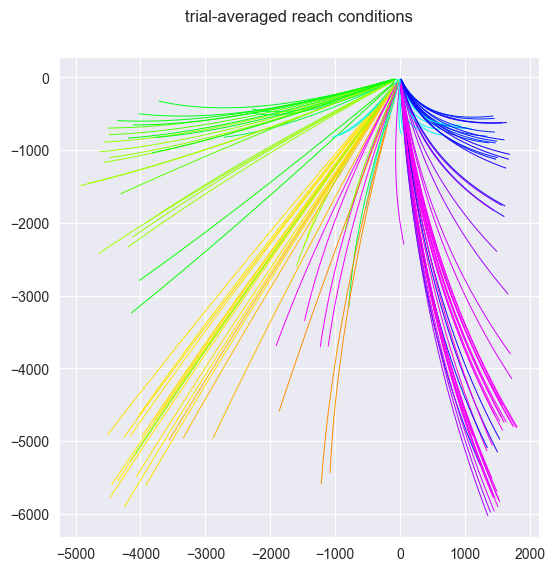

torch.Size([118, 2])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117])


In [151]:
## Plot trial-averaged reaches

# Find unique conditions
maze_conds = trialtable.set_index(['trial_type', 'trial_version']).index.unique().tolist()
maze_conds = [cond for cond in maze_conds if not any(math.isnan(c) for c in cond)]

orig_conds = {}

fig = plt.figure(figsize=(6, 6))
fig.suptitle('trial-averaged reach conditions')
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# Loop over conditions and compute average trajectory
for cond_idx, cond in enumerate(maze_conds):
    # Find trials in condition
    mask = np.all(trialtable[['trial_type', 'trial_version']] == cond, axis=1)
    trials = trialtable[mask]
    traj = torch.cumsum(hand_pos[mask].mean(axis=0), axis=0) #- hand_pos[mask].mean(dim=0)[0]
    # Determine reach angle for color
    #reach_angle = torch.atan2(traj[ -1, 0], traj[-1, 1])
    true_target = true_targets[mask][0]
    reach_angle = np.atan2(true_target[0], true_target[1])
    #reach_angles_deg = torch.rad2deg(reach_angle) + 360 / 2
    reach_colors = plt.cm.hsv(reach_angle / (2 * np.pi) + 0.5)

    # Plot reach
    ax.plot(traj[:, 0], traj[:, 1], linewidth=0.7, color=plt.cm.hsv(reach_angle / (2*np.pi) + 0.5))
    
    orig_conds[cond_idx] = trials.trial_id.drop_duplicates().values
    
maze_conds = torch.tensor(maze_conds)
    
#plt.axis('off')
plt.show()
'''
conds = []
for trial_id, trial in trial_data.groupby('trial_id'):
    trial_id_trial_info = trial_info[trial_info['trial_id'] == trial_id]
    
    for cond, trial_ids in orig_conds.items():
        if trial_id in trial_ids:
            conds.append(cond)
            break
conds = torch.tensor(conds)
'''          
maze_conds = torch.tensor(maze_conds)

print(maze_conds.shape)
print(orig_conds.keys())

In [152]:
def get_avg_trajectory(reaches: torch.Tensor, conds:torch.Tensor, cond: int) -> torch.Tensor:
    
    return torch.mean(reaches[conds == cond], axis=0)


def sort_cond_trajectories_by_deviation(reaches: torch.Tensor, conds:torch.Tensor, cond: int) -> torch.Tensor:
    
    trajectories = reaches[conds == cond]
    n_trajectories, _, _ = trajectories.shape
    avg_reach = torch.mean(trajectories, axis=0)
    
    return trajectories[torch.sort(torch.tensor([dis for dis in [torch.norm(trajectories[ri] - avg_reach) for ri in range(n_trajectories)]]))[1]]


def plot_trajectories(reaches: torch.Tensor, conds: torch.Tensor, cond_to_plot:int, true_targets:np.ndarray):
    
    # get the trajectories from that condition
    trajectories = reaches[conds == cond_to_plot]
    avg_reach = torch.mean(trajectories, axis=0)

    true_target = true_targets[conds == cond_to_plot][0]
    
    fig = plt.figure(figsize=(6, 6))
    #fig.suptitle(f'{obj} {mes} in the condition with the highest standard deviation', fontsize=12)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    for traj in trajectories:
        reach_angle = np.arctan2(traj[-1, 0], traj[-1, 1])
        ax.plot(traj[:, 0], traj[:, 1], linewidth=1.0, color='navy', alpha=0.05, zorder=2, label='single reaches' if (traj==trajectories[-1]).all().item() else '')
        
    ax.scatter(true_target[0], true_target[1], color='skyblue', alpha=0.6, marker='s', s=50.0,zorder=1, label='true target')
    ax.scatter(0, 0, c='pink', marker='o', alpha=0.6, s=50.0, zorder=1, label='init fixation point')
        
    ax.plot(avg_reach[:, 0], avg_reach[:, 1], linewidth=2.0, color='navy', alpha=0.6, zorder=3, label='average trajectory')
    #ax.plot(inacc_traj[:, 0], inacc_traj[:, 1], linewidth=2.0, color='coral', alpha=0.8, zorder=4, label='most inaccurate target hit')
    #ax.plot(dev_traj[:, 0], dev_traj[:, 1], linewidth=2.0, color='gold', alpha=0.8, zorder=5, label='most deviated trajectory')
        
    # Maze frame (from the experiment)
    #ax.set_xlim(-200+20, 200-20)
    #ax.set_ylim(-155+20, 155-20)
    ax.set_xlim(plt.xlim()[0] - 100, plt.xlim()[1])
    ax.set_ylim(plt.ylim()[0], plt.ylim()[1] + 100)
    
    #plt.axis('off')
    plt.legend(fontsize=6, loc='upper left')
    #fig.savefig(f'{obj}_{mes}_most_dispersed_condition.pdf', bbox_inches='tight')
    plt.show()

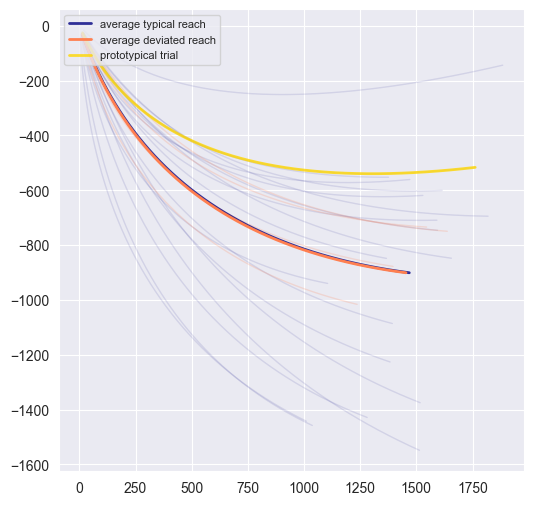

In [159]:
def plot_cond_typ_dev_trajectories(trialtable: pd.DataFrame, reaches, conds: torch.Tensor, cond_to_plot:int, true_targets:np.ndarray):
    
    typ_trials = trialtable[trialtable.correct_reach == 1].reset_index()
    dev_trials = trialtable[trialtable.correct_reach == 0].reset_index()
    
    proto_trials = trialtable[trialtable.proto_trial == 1]
    cond_proto_trial = proto_trials[trialtable[trialtable.proto_trial == 1].maze_condition == cond_to_plot]
    cond_proto_reach = torch.cumsum(reaches[cond_proto_trial.trial_id.values[0]], axis=0)
    
    typ_conds = conds[typ_trials.trial_id.values]
    dev_conds = conds[dev_trials.trial_id.values]
    
    trajectories = reaches[conds == cond_to_plot]
    typ_trajectories = reaches[typ_trials.trial_id.values][typ_conds == cond_to_plot]
    dev_trajectories = reaches[dev_trials.trial_id.values][dev_conds == cond_to_plot]
    
    avg_reach = torch.cumsum(torch.mean(trajectories, axis=0), axis=0)
    avg_typ_reach = torch.cumsum(torch.mean(typ_trajectories, axis=0), axis=0)
    avg_dev_reach = torch.cumsum(torch.mean(dev_trajectories, axis=0), axis=0)
    
    true_target = true_targets[conds == cond_to_plot][0]
    #true_target = torch.tensor(true_target) * avg_reach[-1] / torch.mean(trajectories, axis=0)[-1]
    
    #fig= plt.figure(figsize=(6, 6))
    #ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    fig, ax = plt.subplots(figsize=(6, 6))
    
    for traj in typ_trajectories:
        traj = torch.cumsum(traj, axis=0)
        ax.plot(traj[:, 0], traj[:, 1], linewidth=1.0, color='navy', alpha=0.1, zorder=2, label='single typical  reaches' if (traj==typ_trajectories[-1]).all().item() else '')
    ax.plot(avg_typ_reach[:, 0], avg_reach[:, 1], linewidth=2.0, color='navy', alpha=0.8, zorder=3, label='average typical reach')
    
    for traj in dev_trajectories:
        traj = torch.cumsum(traj, axis=0)
        ax.plot(traj[:, 0], traj[:, 1], linewidth=1.0, color='coral', alpha=0.2, zorder=2, label='single deviated reaches' if (traj==dev_trajectories[-1]).all().item() else '')
    ax.plot(avg_dev_reach[:, 0], avg_reach[:, 1], linewidth=2.0, color='coral', alpha=1.0, zorder=3, label='average deviated reach')
    
    ax.plot(cond_proto_reach[:, 0], cond_proto_reach[:, 1], linewidth=2.0, color='gold', alpha=0.8, zorder=3, label='prototypical trial')
    #ax.scatter(true_target[0], true_target[1], color='skyblue', alpha=0.6, marker='s', s=50.0,zorder=1, label='true target')
    
    plt.legend(fontsize=8, loc='upper left')
    fig.savefig('/home/makki/opium/output_figs/average_reach_2.pdf', bbox_inches='tight')
    plt.show()
    
plot_cond_typ_dev_trajectories(trialtable, hand_pos, conds, 3, true_targets)

In [161]:
proto_trials = trialtable[trialtable.proto_trial == 1]
cond_proto_trial = proto_trials[trialtable[trialtable.proto_trial == 1].maze_condition == 3]
cond_proto_reach = hand_pos[cond_proto_trial.trial_id.values[0]]
cond_proto_reach.shape

torch.Size([50, 2])

In [593]:
torch.cumsum(cond_proto_reach, axis=0) / torch.sum(hand_pos[cond_proto_trial.trial_id.values[0]])

tensor([[ 5.3027e-01, -1.4368e-01],
        [ 1.0611e+00, -2.8608e-01],
        [ 1.5924e+00, -4.2721e-01],
        ...,
        [ 6.8662e+02,  3.8335e+02],
        [ 6.8762e+02,  3.8435e+02],
        [ 6.8862e+02,  3.8535e+02]])

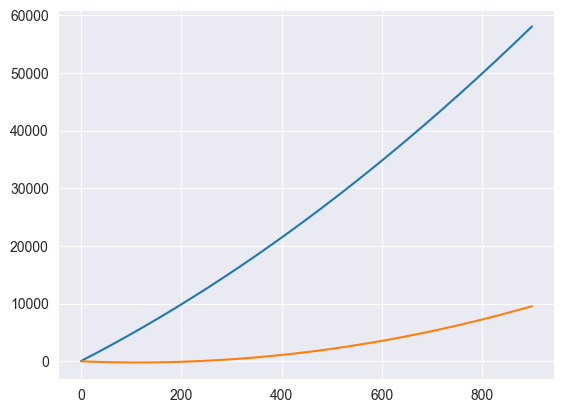

In [566]:
plt.plot(torch.cumsum(cond_proto_reach[0], axis=0))

In [539]:
trialtable[trialtable.proto_trial == 1][trialtable[trialtable.proto_trial == 1].maze_condition == 3]

,id,start_time,stop_time,target_presentation_time,go_cue_time,reaction_time,move_begins_time,move_ends_time,discard_trial,task_success,...,maze_num_targets,maze_num_barriers,novel_maze,target_positions,frame_details,hit_target_position,target_size,barrier_info,timeseries,trial_id
1036,1061,5846.521533,5849.611767,5847.292533,5847.473533,0.41,5847.843533,5848.268533,0,1,...,3,6,0,"[[111, 85], [133, -80], [-116, -5]]","[[[-200]], [[200]], [[-155]], [[155]], [[20]]]","[111, 85]",13,"[[-69.0, -16.0, 69.0, 13.0], [-120.0, -62.0, 15.0, 83.0], [-100.0, 93.0, 62.0, 8.0], [72.0, 98.0, 57.0, 9.0], [64.0, -97.0, 58.0, 15.0], [127.0, -49.0, 7.0, 64.0]]","[(3223161, 2446, Eye pynwb.behavior.SpatialSeries at 0x140135964140560\nFields:\n comments: no comments\n conversion: nan\n data: <HDF5 dataset ""data"": shape (8005321, 2), type ""<f8"">\n description: no description\n interval: 1\n offset: 0.0\n reference_frame: screen center\n resolution: -1.0\n timestamps: <HDF5 dataset ""timestamps"": shape (8005321,), type ""<f8"">\n timestamps_unit: seconds\n unit: meters\n), (3223161, 2446, Hand pynwb.behavior.SpatialSeries at 0x140135963396240\nFields:\n comments: no comments\n conversion: nan\n data: <HDF5 dataset ""data"": shape (8005321, 2), type ""<f8"">\n description: no description\n interval: 1\n offset: 0.0\n reference_frame: screen center\n resolution: -1.0\n timestamps: <HDF5 dataset ""timestamps"": shape (8005321,), type ""<f8"">\n timestamps_unit: seconds\n unit: meters\n), (3223161, 2446, Cursor pynwb.behavior.SpatialSeries at 0x140135964143312\nFields:\n comments: no comments\n conversion: nan\n data: <HDF5 dataset ""data"": shape (8005321, 2), type ""<f8"">\n description: no description\n interval: 1\n offset: 0.0\n reference_frame: screen center\n resolution: -1.0\n timestamps: <HDF5 dataset ""timestamps"": shape (8005321,), type ""<f8"">\n timestamps_unit: seconds\n unit: meters\n)]",1036


In [534]:
true_targets[conds == 3][0]

array([111,  85], dtype=int16)

In [536]:
hand_pos[conds == 3][0][-1]

tensor([73.3119, 25.5522])

In [ ]:
x = true_targets[0]

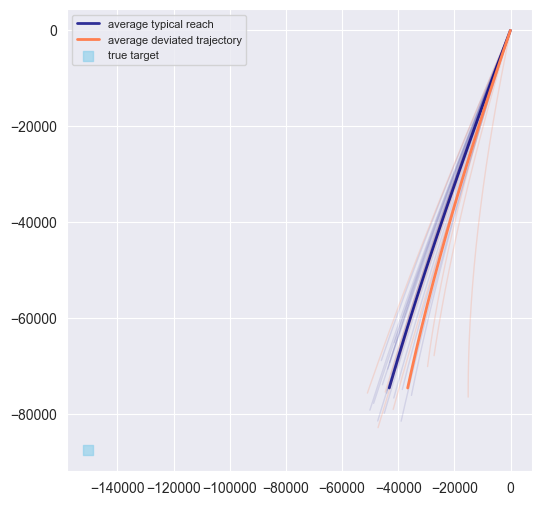

<Figure size 640x480 with 0 Axes>

In [521]:
plot_cond_typ_dev_trajectories(trialtable, hand_pos, conds, 51, true_targets)

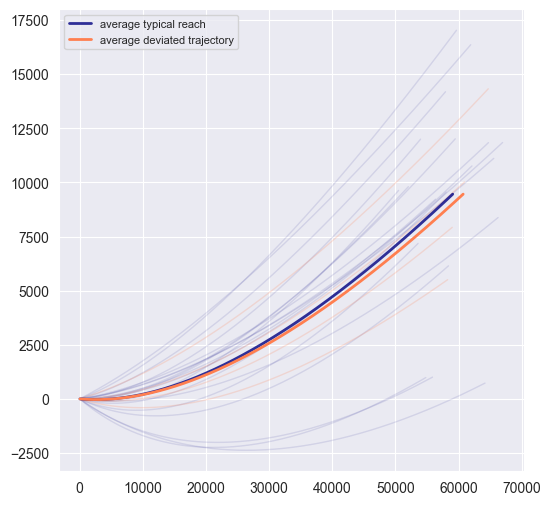

<Figure size 640x480 with 0 Axes>

In [537]:
plot_cond_typ_dev_trajectories(trialtable, hand_pos, conds, 3, true_targets)

In [481]:
hand_pos[0, -1]

tensor([-36.7643, -46.7751])

In [484]:
true_targets[0]

array([-130,  -57], dtype=int16)

In [494]:
def scaled_cumsum(hand_position):
    # Ensure the input is a torch tensor
    if not isinstance(hand_position, torch.Tensor):
        hand_position = torch.tensor(hand_position, dtype=torch.float32)
    
    # Step 1: Calculate cumulative sum of the differences in position
    displacements = torch.diff(hand_position, dim=0)
    cumulative_trajectory = torch.cumsum(displacements, dim=0)
    
    # Step 2: Add the starting position to the cumulative sum result
    cumulative_trajectory = torch.vstack((hand_position[0].unsqueeze(0), cumulative_trajectory + hand_position[0]))

    # Step 3: Scale the cumulative trajectory to ensure it ends at the same point as the original
    scaling_offset = hand_position[-1] - cumulative_trajectory[-1]
    scaled_trajectory = cumulative_trajectory + scaling_offset
    
    return scaled_trajectory

# Example usage
# Assuming `hand_position` is an Nx2 array with x, y positions
scaled_cumsum(hand_pos[0])


tensor([[-64.7460, -63.1424],
        [-64.7149, -63.1242],
        [-64.6837, -63.1060],
        ...,
        [-36.8266, -46.8116],
        [-36.7954, -46.7933],
        [-36.7643, -46.7751]])

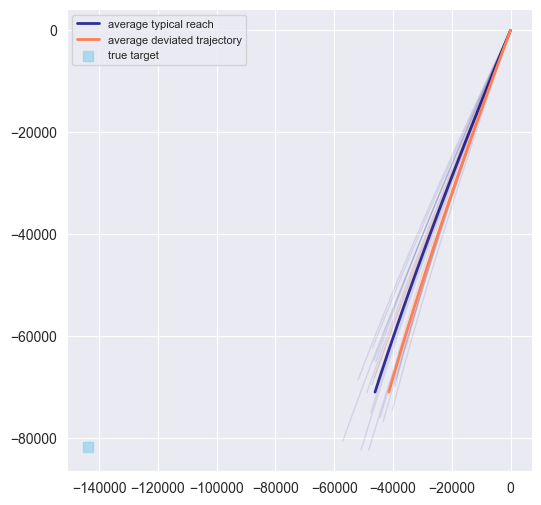

<Figure size 640x480 with 0 Axes>

In [523]:
plot_cond_typ_dev_trajectories(trialtable, hand_pos, conds, 15, true_targets)

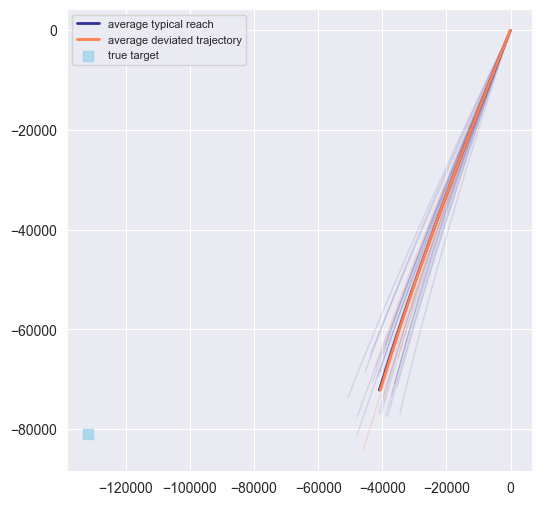

<Figure size 640x480 with 0 Axes>

In [524]:
plot_cond_typ_dev_trajectories(trialtable, hand_pos, conds, 90, true_targets)

In [458]:
def pos_to_vel(pos: np.ndarray, dt: float) -> torch.Tensor:
    return np.diff(pos, axis=0) / dt

vel =  pos_to_vel(hand_pos, 0.001)

In [473]:
def calculate_velocity(hand_position, dt):
    # Calculate velocity as the finite difference between positions
    velocity = np.diff(hand_position, axis=0) / dt
    # Add a row of zeros at the beginning to keep velocity the same length as position
    velocity = np.vstack(([0, 0], velocity))
    return velocity

# Example usage with dt
dt = 0.001  # Assuming 1 ms time interval
velocity = calculate_velocity(hand_pos_binned[0], dt)

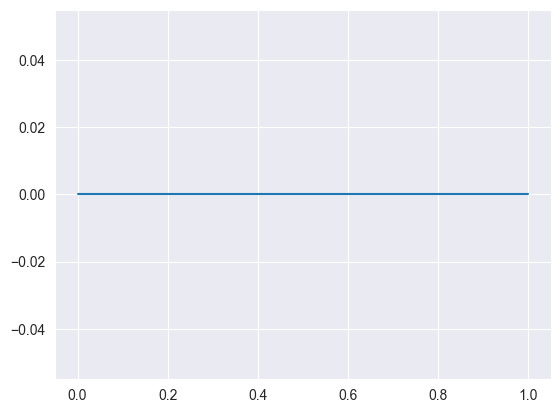

In [474]:
plt.plot(velocity[0])

In [460]:
vel[0][0]

array([98595.73 , 50092.355], dtype=float32)

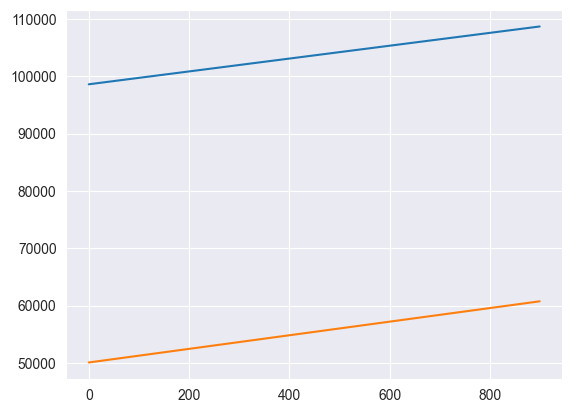

In [462]:
plt.plot(vel[0])

In [ ]:
vel = result = np.concatenate((array1, array2), axis=0)

In [455]:
vel.shape

(2569, 900, 2)

In [442]:
vel[9]

torch.Size([2570, 900, 2])

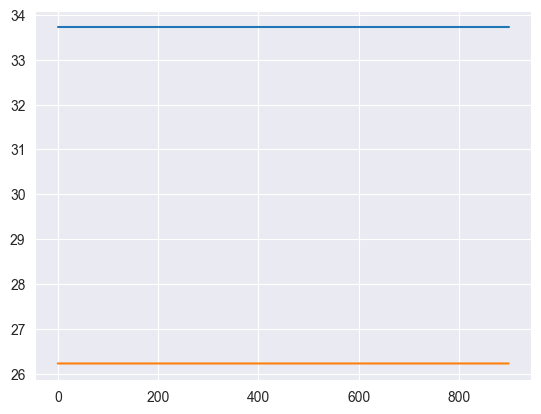

In [450]:
cond_to_plot = 3

typ_trials = trialtable[trialtable.correct_reach == 1].reset_index()
dev_trials = trialtable[trialtable.correct_reach == 0].reset_index()

typ_conds = conds[typ_trials.trial_id.values]
dev_conds = conds[dev_trials.trial_id.values]

trajectories = hand_vel[conds == cond_to_plot]
typ_trajectories = hand_vel[typ_trials.trial_id.values][typ_conds == cond_to_plot]
dev_trajectories = hand_vel[dev_trials.trial_id.values][dev_conds == cond_to_plot]

avg_reach = torch.mean(trajectories, axis=0)
avg_typ_reach = torch.mean(typ_trajectories, axis=0)
avg_dev_reach = torch.mean(dev_trajectories, axis=0)

plt.plot(avg_reach)

In [434]:
avg_reach

tensor([[33.7205, 26.2238],
        [33.7205, 26.2238],
        [33.7205, 26.2238],
        ...,
        [33.7205, 26.2237],
        [33.7205, 26.2237],
        [33.7205, 26.2237]])

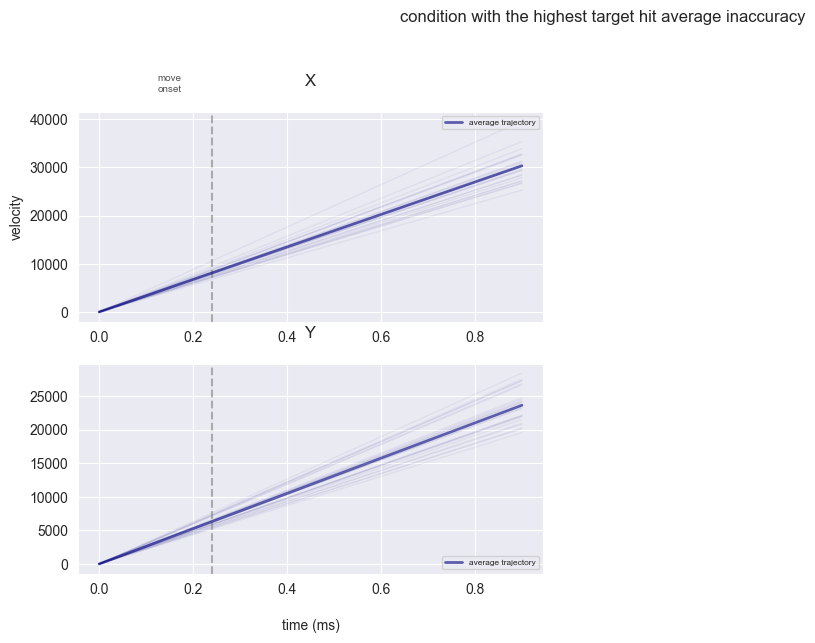

In [419]:
reaches = hand_vel
cond_to_plot = 3

typ_trials = trialtable[trialtable.correct_reach == 1].reset_index()
dev_trials = trialtable[trialtable.correct_reach == 0].reset_index()

typ_conds = conds[typ_trials.trial_id.values]
dev_conds = conds[dev_trials.trial_id.values]

trajectories = reaches[conds == cond_to_plot]
typ_trajectories = reaches[typ_trials.trial_id.values][typ_conds == cond_to_plot]
dev_trajectories = reaches[dev_trials.trial_id.values][dev_conds == cond_to_plot]

avg_reach = torch.cumsum(torch.mean(trajectories, axis=0), axis=0)
avg_typ_reach = torch.cumsum(torch.mean(typ_trajectories, axis=0), axis=0)
avg_dev_reach = torch.cumsum(torch.mean(dev_trajectories, axis=0), axis=0)

true_target = true_targets[conds == cond_to_plot][0]

fig, axes = plt.subplots(2, figsize=(6, 6))
axx = axes[0]
axy = axes[1]

cond_idx = cond_to_plot

for traj in trajectories:
    traj = torch.cumsum(traj, axis=0)
    reach_angle = np.arctan2(traj[-1, 0], traj[-1, 1])
    axx.plot(torch.arange(0, traj[:, 0].shape[0], 1)*BINSIZE, traj[:, 0], linewidth=1.0, color='navy', alpha=0.05, zorder=2, label='single reaches' if (traj==trajectories[-1]).all().item() else '')
    axy.plot(torch.arange(0, traj[:, 1].shape[0], 1)*BINSIZE, traj[:, 1], linewidth=1.0, color='navy', alpha=0.05, zorder=2, label='single reaches' if (traj==trajectories[-1]).all().item() else '')
    
axx.plot(torch.arange(0, avg_reach[:, 0].shape[0], 1)*BINSIZE, avg_reach[:, 0], linewidth=2.0, color='navy', alpha=0.6, zorder=3, label='average trajectory')
axy.plot(torch.arange(0, avg_reach[:, 1].shape[0], 1)*BINSIZE, avg_reach[:, 1], linewidth=2.0, color='navy', alpha=0.6, zorder=3, label='average trajectory')

axx.axvline(x=BINS_BEFORE*BINSIZE, color='gray', alpha=0.6, linestyle='--')
axy.axvline(x=BINS_BEFORE*BINSIZE, color='gray', alpha=0.6, linestyle='--')

axx.annotate(f"move\nonset",
            xy=(BINS_BEFORE*BINSIZE, axx.get_ylim()[1]),
            xytext=(BINS_BEFORE * BINSIZE - (N_BINS * BINSIZE * 0.1), (axx.get_ylim()[1] * 1.1)),
            arrowprops=dict(facecolor='black', alpha=0.4, arrowstyle='->'),
            fontsize=7, alpha=0.8, ha='center')

#plt.axis('off')
axx.set_title('X\n') 
axx.legend(fontsize=6, loc='upper right')
axx.set_ylabel(f'velocity', fontsize=10)
axy.set_title('Y\n') 
axy.legend(fontsize=6, loc='lower right')
axy.set_xlabel('\ntime (ms)', fontsize=10)
#fig.suptitle(f'condition with the highest standard deviation\n\n', fontsize=12)
fig.text(1, 0.95, f'condition with the highest target hit average inaccuracy\n\n\n\n\n\n', ha='center', va='center', fontsize=12)

fig.savefig(f'velocity.pdf', bbox_inches='tight')
plt.show()

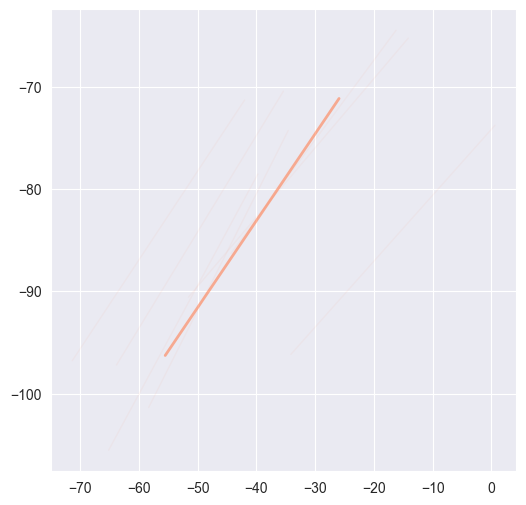

In [144]:
mask = dev_trials.trial_id.values

dev_reaches = hand_pos[mask]
dev_conds = conds[mask]

trajectories = dev_reaches[dev_conds == 51]
avg_reach = torch.mean(trajectories, axis=0)
true_target = true_targets[conds == 0][0]

#fig= plt.figure(figsize=(6, 6))
#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
fig, ax = plt.subplots(figsize=(6, 6))

for traj in trajectories:
    ax.plot(traj[:, 0], traj[:, 1], linewidth=1.0, color='coral', alpha=0.05, zorder=2, label='single reaches' if (traj==trajectories[-1]).all().item() else '')
    
ax.plot(avg_reach[:, 0], avg_reach[:, 1], linewidth=2.0, color='coral', alpha=0.6, zorder=3, label='average trajectory')
    
plt.show()

In [ ]:
mask = dev_trials.trial_id.values

typ_reaches = hand_pos[mask]
dev_conds = conds[mask]

trajectories = dev_reaches[dev_conds == 51]
avg_reach = torch.mean(trajectories, axis=0)
true_target = true_targets[conds == 0][0]

#fig= plt.figure(figsize=(6, 6))
#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
fig, ax = plt.subplots(figsize=(6, 6))

for traj in trajectories:
    ax.plot(traj[:, 0], traj[:, 1], linewidth=1.0, color='coral', alpha=0.05, zorder=2, label='single reaches' if (traj==trajectories[-1]).all().item() else '')
    
ax.plot(avg_reach[:, 0], avg_reach[:, 1], linewidth=2.0, color='coral', alpha=0.6, zorder=3, label='average trajectory')
    
plt.show()

In [452]:
hand_pos[typ_trials.trial_id.values].shape

torch.Size([2296, 900, 2])

In [453]:
conds.shape

(2570,)

IndexError: boolean index did not match indexed array along axis 0; size of axis is 2570 but size of corresponding boolean axis is 274

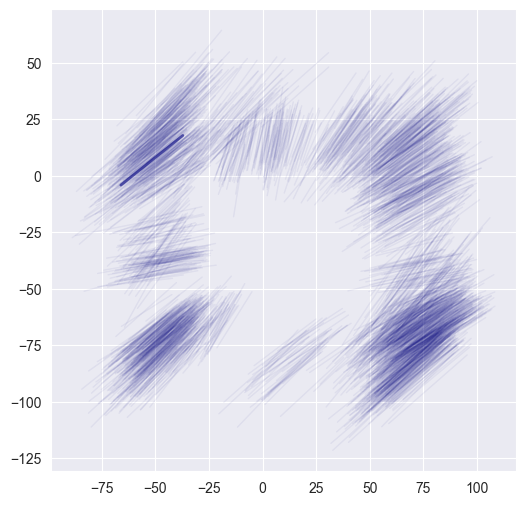

In [450]:
typ_reaches = hand_pos[typ_trials.trial_id.values]
typ_conds = conds[typ_trials.trial_id.values]
dev_reaches = hand_pos[dev_trials.trial_id.values]
dev_conds = conds[dev_trials.trial_id.values]

trajectories = hand_pos[typ_trials.trial_id.values][typ_conds == 9]
avg_reach = torch.mean(trajectories, axis=0)
true_target = true_targets[conds == 9][0]

#fig= plt.figure(figsize=(6, 6))
#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
fig, ax = plt.subplots(figsize=(6, 6))

for traj in typ_reaches:
    ax.plot(traj[:, 0], traj[:, 1], linewidth=1.0, color='navy', alpha=0.05, zorder=2, label='single reaches' if (traj==trajectories[-1]).all().item() else '')
    
ax.plot(avg_reach[:, 0], avg_reach[:, 1], linewidth=2.0, color='navy', alpha=0.6, zorder=3, label='average trajectory')

trajectories = hand_pos[dev_trials.trial_id.values][dev_conds == 9]
avg_reach = torch.mean(trajectories, axis=0)
true_target = true_targets[dev_conds == 9][0]

for traj in dev_reaches:
    ax.plot(traj[:, 0], traj[:, 1], linewidth=1.0, color='coral', alpha=0.05, zorder=2, label='single reaches' if (traj==trajectories[-1]).all().item() else '')
    
ax.plot(avg_reach[:, 0], avg_reach[:, 1], linewidth=2.0, color='coral', alpha=0.6, zorder=3, label='average trajectory')
    
plt.show()

/tmp/ipykernel_4008035/3501011618.py:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  reach_angle = np.arctan2(traj[-1, 0], traj[-1, 1])


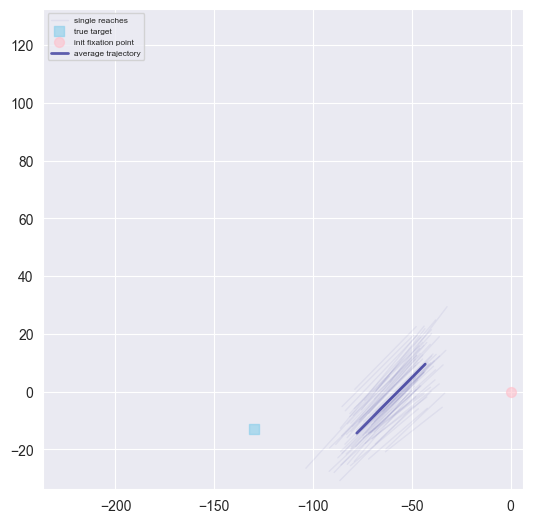

In [280]:
plot_trajectories(hand_pos, conds, 27, true_targets)

In [ ]:
def plot_cond_typ_dev_trajectories(trialtable: pd.DataFrame, reaches, conds: torch.Tensor, cond_to_plot:int, true_targets:np.ndarray):
    
    typ_trials = trialtable[trialtable.correct_reach == 1].reset_index()
    dev_trials = trialtable[trialtable.correct_reach == 0].reset_index()
    
    proto_trials = trialtable[trialtable.proto_trial == 1]
    cond_proto_trial = proto_trials[trialtable[trialtable.proto_trial == 1].maze_condition == cond_to_plot]
    cond_proto_reach = reaches[cond_proto_trial.trial_id.values[0]]
    
    typ_conds = conds[typ_trials.trial_id.values]
    dev_conds = conds[dev_trials.trial_id.values]
    
    trajectories = reaches[conds == cond_to_plot]
    typ_trajectories = reaches[typ_trials.trial_id.values][typ_conds == cond_to_plot]
    dev_trajectories = reaches[dev_trials.trial_id.values][dev_conds == cond_to_plot]
    
    avg_reach = torch.mean(trajectories, axis=0)
    avg_typ_reach = torch.mean(typ_trajectories, axis=0)
    avg_dev_reach = torch.mean(dev_trajectories, axis=0)
    
    true_target = true_targets[conds == cond_to_plot][0]
    #true_target = torch.tensor(true_target) * avg_reach[-1] / torch.mean(trajectories, axis=0)[-1]
    
    #fig= plt.figure(figsize=(6, 6))
    #ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    fig, ax = plt.subplots(figsize=(6, 6))
    
    for traj in typ_trajectories:
        ax.plot(traj[:, 0], traj[:, 1], linewidth=1.0, color='navy', alpha=0.1, zorder=2)#, label='single typical  reaches' if (traj==typ_trajectories[-1]).all().item() else '')
    ax.plot(avg_typ_reach[:, 0], avg_reach[:, 1], linewidth=2.0, color='navy', alpha=0.8, zorder=3, label='average typical reach')
    
    for traj in dev_trajectories:
        ax.plot(traj[:, 0], traj[:, 1], linewidth=1.0, color='gold', alpha=0.2, zorder=2)#, label='single deviated reaches' if (traj==dev_trajectories[-1]).all().item() else '')
    ax.plot(avg_dev_reach[:, 0], avg_reach[:, 1], linewidth=2.0, color='gold', alpha=1.0, zorder=3, label='average deviated reach')
    
    ax.plot(cond_proto_reach[:, 0], cond_proto_reach[:, 1], linewidth=2.0, color='coral', alpha=0.8, zorder=3, label='prototypical trial')
    ax.scatter(true_target[0], true_target[1], color='skyblue', alpha=0.6, marker='s', s=50.0,zorder=1, label='true target')
    
    plt.legend(fontsize=8, loc='upper left')
    plt.show()
    plt.savefig('/home/makki/opium/output_figs/average_reach_2.pdf')
    
plot_cond_typ_dev_trajectories(trialtable, hand_pos, conds, 3, true_targets)